# 🚨 Malicious Twitter Bot Detection using Logistic Regression

This notebook trains a machine learning model to detect Twitter bot accounts based on tweet metadata features: Activity, Anonymity, and Amplification.

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
from google.colab import files
uploaded = files.upload()

# After uploading, it should be something like 'kaggle_tweets.csv'
import io
df = pd.read_csv(io.BytesIO(uploaded['kaggle_tweets.csv']))  # Replace with actual file name if needed
df.head()


Saving kaggle_tweets.csv to kaggle_tweets.csv


,id,id_str,screen_name,location,description,url,followers_count,friends_count,listedcount,created_at,favourites_count,verified,statuses_count,lang,status,default_profile,default_profile_image,has_extended_profile,name,bot
0,8.160000e+17,"""815745789754417152""","""HoustonPokeMap""","""Houston, TX""","""Rare and strong PokŽmon in Houston, TX. See m...","""https://t.co/dnWuDbFRkt""",1291,0,10,"""Mon Jan 02 02:25:26 +0000 2017""",0,False,78554,"""en""","{\r ""created_at"": ""Sun Mar 12 15:44:04 +0...",True,False,False,"""Houston PokŽ Alert""",1
1,4.843621e+09,4843621225,kernyeahx,"Templeville town, MD, USA",From late 2014 Socium Marketplace will make sh...,NaN,1,349,0,2/1/2016 7:37,38,False,31,en,NaN,True,False,False,Keri Nelson,1
2,4.303727e+09,4303727112,mattlieberisbot,NaN,"Inspired by the smart, funny folks at @replyal...",https://t.co/P1e1o0m4KC,1086,0,14,Fri Nov 20 18:53:22 +0000 2015,0,False,713,en,"{'retweeted': False, 'is_quote_status': False,...",True,False,False,Matt Lieber Is Bot,1
3,3.063139e+09,3063139353,sc_papers,NaN,NaN,NaN,33,0,8,2/25/2015 20:11,0,False,676,en,Construction of human anti-tetanus single-chai...,True,True,False,single cell papers,1
4,2.955142e+09,2955142070,lucarivera16,"Dublin, United States",Inspiring cooks everywhere since 1956.,NaN,11,745,0,1/1/2015 17:44,146,False,185,en,NaN,False,False,False,lucarivera16,1


In [4]:
df.info()
df.describe()
df.columns  # Check column names to use for feature extraction


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2797 entries, 0 to 2796
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2797 non-null   float64
 1   id_str                 2797 non-null   object 
 2   screen_name            2797 non-null   object 
 3   location               1777 non-null   object 
 4   description            2394 non-null   object 
 5   url                    1375 non-null   object 
 6   followers_count        2797 non-null   int64  
 7   friends_count          2797 non-null   int64  
 8   listedcount            2797 non-null   int64  
 9   created_at             2797 non-null   object 
 10  favourites_count       2797 non-null   int64  
 11  verified               2797 non-null   bool   
 12  statuses_count         2797 non-null   int64  
 13  lang                   2797 non-null   object 
 14  status                 2461 non-null   object 
 15  defa

Index(['id', 'id_str', 'screen_name', 'location', 'description', 'url',
       'followers_count', 'friends_count', 'listedcount', 'created_at',
       'favourites_count', 'verified', 'statuses_count', 'lang', 'status',
       'default_profile', 'default_profile_image', 'has_extended_profile',
       'name', 'bot'],
      dtype='object')

In [7]:
# Convert 'created_at' column to datetime with UTC
df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce', utc=True)

# Use UTC timestamp for 'today' as well
today = pd.to_datetime("today", utc=True)

# Calculate account age in days
df['account_age_days'] = (today - df['created_at']).dt.days

# Feature 1: Activity = statuses_count / account age
df['activity'] = df['statuses_count'] / (df['account_age_days'] + 1)

# Feature 2: Anonymity = 1 if NOT verified
df['anonymity'] = (~df['verified']).astype(int)

# Feature 3: Amplification = followers / (friends + 1) to avoid division by 0
df['amplification'] = df['followers_count'] / (df['friends_count'] + 1)

# Final features and target
features = df[['activity', 'anonymity', 'amplification']]
target = df['bot']



In [11]:
# Combine features and target to remove any rows with NaN
data = pd.concat([features, target], axis=1)

# Drop rows where 'activity' is NaN (or any NaN in features)
data.dropna(inplace=True)

# Redefine final feature set and target
features_clean = data[['activity', 'anonymity', 'amplification']]
target_clean = data['bot']


In [13]:
X_train, X_test, y_train, y_test = train_test_split(features_clean, target_clean, test_size=0.2, random_state=42)



In [14]:
# Cell 7: Train the model
model = LogisticRegression()
model.fit(X_train, y_train)


LogisticRegression()

In [16]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy * 100:.2f}%")


Model Accuracy: 68.47%


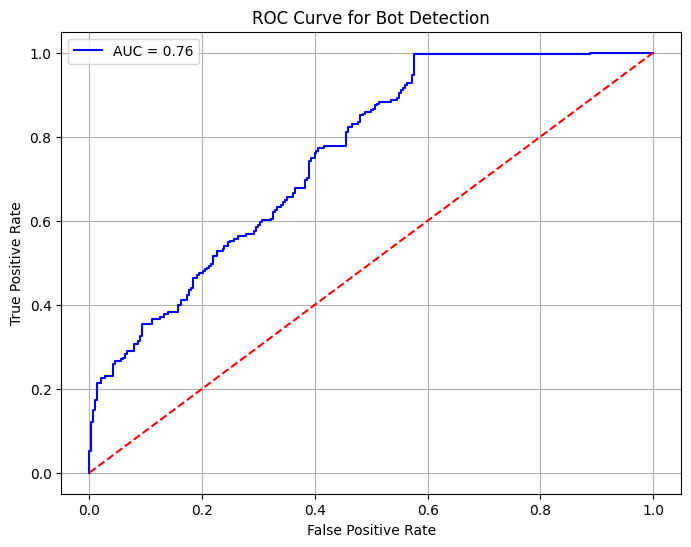

In [17]:
y_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Bot Detection")
plt.legend()
plt.grid(True)
plt.show()


In [19]:
import pickle  # <-- add this if not already imported
from google.colab import files

# Save the model
with open("logistic_model.pkl", "wb") as f:
    pickle.dump(model, f)

# Download to your local machine
files.download("logistic_model.pkl")



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>